### Notes

The folder `src` was originally called: `samples_humanml_trans_enc_512_000200000_seed10_the_person_walked_from_left_to_right`, which is the name of the folder where MDM places its output. 

The prompt that genereated the sequence was: 
>"The person walked from left to right"

The name of this folder is important because it details the MDM model that output the sequence, the epoch where training stopped, and the random seed. 

In [4]:
import numpy as np
from mdm_motion2smpl import pose_seq_3D_to_axis_angle

### Step 1: Extract XYZ Joint Positions from MDM

In [5]:
x = np.load("./results.npy", allow_pickle=True)

In [6]:
single_motion = x[None][0]['motion'][0, :]

In [7]:
single_motion.shape

(22, 3, 196)

### SMPL Joint Index Mapping

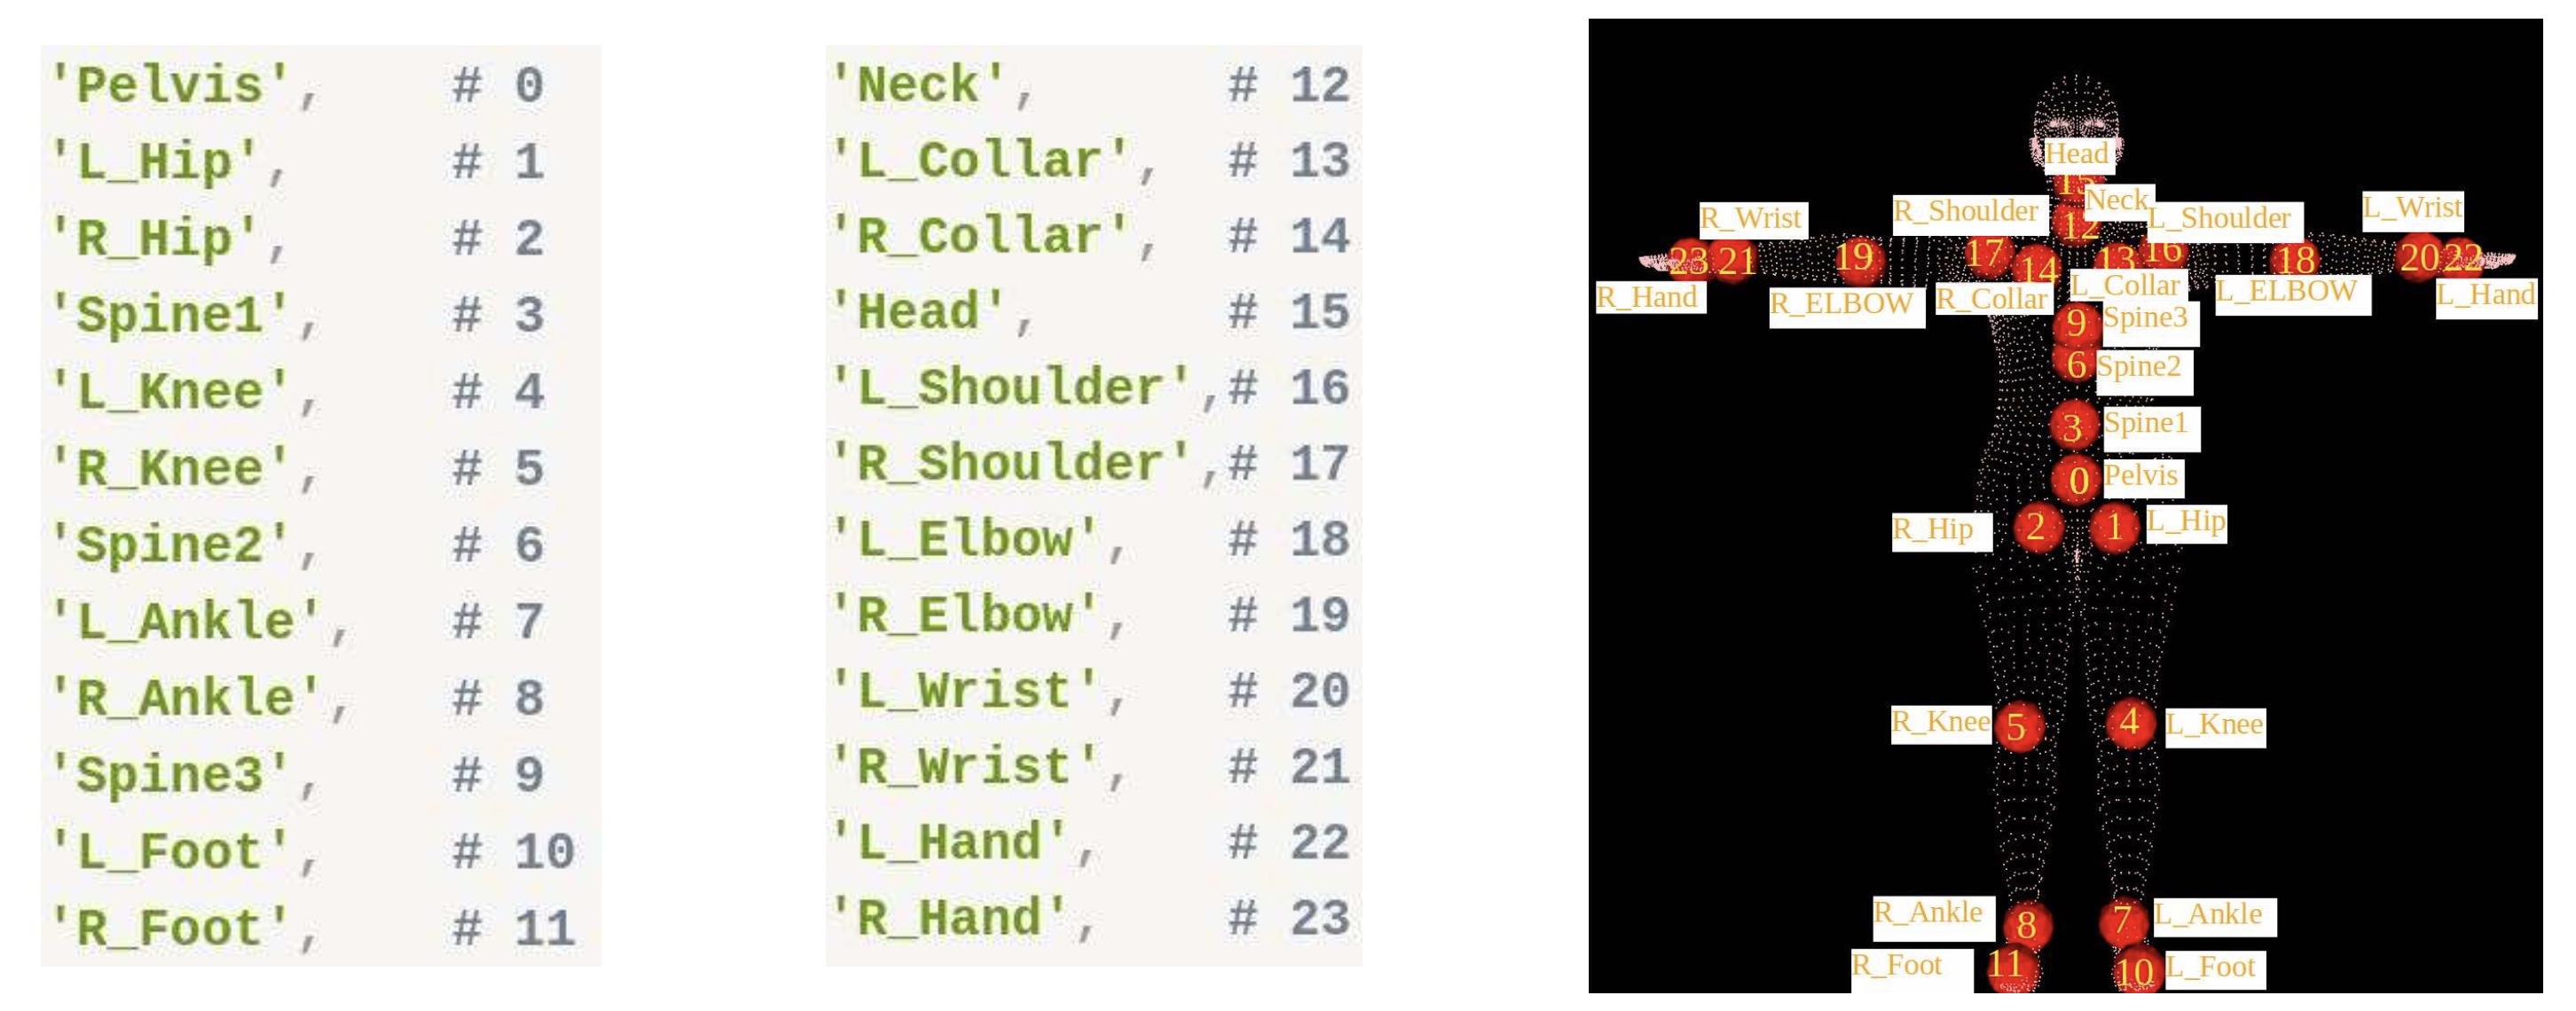

>The above image from "SMPL made Simple FAQs" pp. 23 (PDF file [LINK](https://files.is.tue.mpg.de/black/talks/SMPL-made-simple-FAQs.pdf), website: [LINK](https://smpl-made-simple.is.tue.mpg.de/)). 

In [40]:
L_FOOT_ID = 10
R_FOOT_ID = 11

In [41]:
# [nframes, njoints, 3]
motion_seq = single_motion.transpose(2, 0, 1)

In [42]:
# these are the XYZ positions of the left foot joint in the first frame of the sequence
motion_seq[0][L_FOOT_ID]

array([ 0.00164652,  0.11944745, -0.334422  ], dtype=float32)

### Step 2: Skin it Using VPoser

See this file: [LINK](https://github.com/nate-gillman/motion-diffusion-model/blob/7133c02a83957244cf0d6f49bbd69bd40a8f70f9/mdm_to_uhc_to_mdm.py#L88)

Alternatively, one can use UHC's `SMPL Robot` to extract the vertices and joints given:
- the pose axis angle
- the pose betas (can be null)
- the pose translation

See implementation of that here: [LINK](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/envs/humanoid_im.py#L127)

In [13]:
def get_pose_seq_dict(pose_seq):
    # from: https://github.com/nate-gillman/motion-diffusion-model/blob/7133c02a83957244cf0d6f49bbd69bd40a8f70f9/translation/mdm_to_amass.py#L49
    joints_num = 22
    num_samples = 0
    reps = 0
    n_frames = pose_seq.shape[0]
    pose_seq = np.stack([pose_seq[:, j, :].T for j in range(joints_num)])
    get_pose_seq_dict = {
        'motion': np.array([pose_seq]),
        'text': ['dummy'],
        'lengths': np.array([n_frames]),
        'num_samples': num_samples,
        'num_repetitions': reps
        }
    return get_pose_seq_dict

def mdm_to_amass(pose_seq, model_type='smplh', gender='neutral'):
    pose_seq_dict = get_pose_seq_dict(pose_seq)

    # inverse kinematics step
    amass_rec = pose_seq_3D_to_axis_angle(pose_seq_dict, surface_model_type=model_type, gender=gender)
    return amass_rec

In [14]:
amass_result = mdm_to_amass(motion_seq)

2023-12-31 21:23:45.084 | INFO     | human_body_prior.src.human_body_prior.tools.model_loader:load_model:77 - No GPU detected. Loading on CPU!
2023-12-31 21:23:45.145 | INFO     | human_body_prior.src.human_body_prior.tools.model_loader:load_model:97 - Loaded model in eval mode with trained weights: ./human_body_prior/support_data/dowloads/vposer_v2_05/snapshots/V02_05_epoch=08_val_loss=0.03.ckpt
VPoser Advanced IK: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:23<00:00, 23.82s/it]


In [15]:
# save the output to np file
np.save("./vposer_output.npy", amass_result)

In [16]:
import numpy as np
from typing import Dict

def load_vposer_output() -> Dict:
    # unwrap the weird way numpy saves objects
    _loaded_result = np.load("./vposer_output.npy", allow_pickle=True)
    return _loaded_result[None][0]

In [17]:
# load the saved output
vposer_output = load_vposer_output()

In [18]:
vposer_output['poses'].shape

(196, 165)

In [135]:
vposer_output.keys()

dict_keys(['trans', 'root_orient', 'poZ_body', 'pose_body', 'betas', 'poses', 'surface_model_type', 'gender', 'mocap_framerate', 'num_betas', 'motion_length'])

### Visualization Code

Source: [LINK](https://github.com/nghorbani/body_visualizer)

In [19]:
import torch
from body_visualizer.tools.vis_tools import imagearray2file
from body_visualizer.tools.vis_tools import render_smpl_params
from human_body_prior.src.human_body_prior.body_model.body_model import BodyModel

support_dir = "./human_body_prior/support_data/dowloads"
surface_model_type = "smplh"
gender = "neutral"

import os.path as osp

bm_fname = osp.join(support_dir, f'models/{surface_model_type}/{gender}/model.npz')

# given these properties, linear blend skin it
num_betas = vposer_output['num_betas']
bm = BodyModel(bm_fname=bm_fname, num_betas=num_betas)

# is equal to: len(motion), technically do not need to do this
repeats = vposer_output['motion_length']

res = bm.forward(
    root_orient=torch.from_numpy(vposer_output['root_orient']), 
    pose_body=torch.from_numpy(vposer_output['pose_body']),
    trans=torch.from_numpy(vposer_output['trans']),
    pose_hand=None,
    pose_jaw=None,
    pose_eye=None,
    betas=None,
    dmpls=None,
    expression=None,
    return_dict=True
)

In [20]:
vertices, faces = res['v'], res['f']

In [21]:
faces.shape

torch.Size([13776, 3])

In [22]:
vertices.shape

torch.Size([196, 6890, 3])

### Given the mesh, view it

`render_smpl_params` is from here: [LINK](https://github.com/nghorbani/body_visualizer/blob/5d0ac4615f32563f5dbd2f09c24aee75e3ae62ff/src/body_visualizer/tools/vis_tools.py#L141C1-L175C52)

Refer also to `rotateXYZ`: [LINK](https://github.com/nghorbani/body_visualizer/blob/5d0ac4615f32563f5dbd2f09c24aee75e3ae62ff/src/body_visualizer/tools/mesh_tools.py#L14)

See also the `MeshViewer` class here: [LINK](https://github.com/nghorbani/body_visualizer/blob/5d0ac4615f32563f5dbd2f09c24aee75e3ae62ff/src/body_visualizer/mesh/mesh_viewer.py#L37)

In [23]:
import os
import cv2
import trimesh
# weird hack to remove the bug: https://github.com/mkocabas/VIBE/issues/101
# "dlopen(EGL, 0x000A): tried: 'EGL' (no such file)"
_k = 'PYOPENGL_PLATFORM'
if _k in os.environ:
    del os.environ['PYOPENGL_PLATFORM']

from body_visualizer.mesh.mesh_viewer import MeshViewer
from body_visualizer.tools.mesh_tools import rotateXYZ



def render_smpl_params(vertices, faces, img_width: int = 800, img_height: int = 800, rot_body=None, camera_translation=None):
    """
    :param bm: pytorch body model with batch_size 1
    :param pose_body: Nx21x3
    :param trans: Nx3
    :param betas: Nxnum_betas
    :return: N x 400 x 400 x 3
    """
    imw, imh = img_width, img_height
    
    # use_offscren must be True! On mac os
    mv = MeshViewer(width=imw, height=imh, use_offscreen=True)
    
    # zoom way out on the z plane to give more room to see the full sequence
    if camera_translation is None:
        # use this very zoomed out default
        mv.set_cam_trans([0.0, 2.0, 10.0])
    else:
        mv.set_cam_trans(camera_translation)
    
    v = vertices

    T, num_verts = v.shape[:-1]

    images = []
    for fIdx in range(T):
        verts = v[fIdx]
        if rot_body is not None:
            verts = rotateXYZ(verts, rot_body)
            
        mesh = trimesh.base.Trimesh(
            verts, 
            faces, 
        )

        mv.set_meshes([mesh], 'static')

        images.append(mv.render())
        

    return np.array(images).reshape(T, imw, imh, 3)

def imagearray2file(img_array, outpath=None, fps=30):
    """
    :param nparray: R x C x T x height x width x 3
    :param outpath: the directory where T images will be dumped for each time point in range T
    :param fps: fps of the gif file
    :return:
        it will return an image list with length T
        if outpath is given as a png file, an image will be saved for each t in T.
        if outpath is given as a gif file, an animated image with T frames will be created.
    """

    if outpath is not None:
        outdir = os.path.dirname(outpath)
        if not os.path.exists(outdir): 
            os.makedirs(outdir)

    if not isinstance(img_array, np.ndarray) or img_array.ndim < 6:
        raise ValueError('img_array should be a numpy array of shape R x C x T x height x width x 3')

    R, C, T, img_h, img_w, img_c = img_array.shape

    out_images = []
    for tIdx in range(T):
        row_images = []
        for rIdx in range(R):
            col_images = []
            for cIdx in range(C):
                col_images.append(img_array[rIdx, cIdx, tIdx])
            row_images.append(np.hstack(col_images))
        t_image = np.vstack(row_images)
        out_images.append(t_image)

    if outpath is not None:
        ext = outpath.split('.')[-1]
        if ext in ['png', 'jpeg', 'jpg']:
            for tIdx in range(T):
                if T > 1:
                    cur_outpath = outpath.replace('.%s'%ext, '_%03d.%s'%(tIdx, ext))
                else:
                    cur_outpath = outpath
                    
                img = cv2.cvtColor(out_images[tIdx], cv2.COLOR_BGR2RGB)
                
                # image is of shape: (width, height, color_channels)
                cv2.imwrite(cur_outpath, img)
                while not os.path.exists(cur_outpath): 
                    # wait until the snapshot is written to the disk
                    continue
        elif ext == 'gif':
            import imageio
            
            # more info: https://imageio.readthedocs.io/en/stable/reference/userapi.html#imageio.v2.get_writer
            with imageio.get_writer(outpath, mode='I', fps=fps, loop=0) as writer:
                for tIdx in range(T):
                    img = out_images[tIdx].astype(np.uint8)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    writer.append_data(img)
                    
                # writer.set_meta_data({"loop": "infinite"})
    return out_images

In [24]:
def vertices_and_faces_to_video(body_model_result, output_path: str, h: int = 800, w: int = 800) -> None:
    # given the output of the vposer model, produce a video of given dimensions
    vertices, faces = body_model_result['v'], body_model_result['f']
    
    # the rot_body specifies, in degrees, how to rotate the mesh. We do this for visualization purposes
    # but not recommended to do it when computing metrics. 
    images = render_smpl_params(vertices, faces, img_width=w, img_height=h, rot_body=[-90,0,0])

    # dimensions are: R x C x sequence_length x img_height x img_width x num_color_channels (RGB)
    t = vertices.shape[0]
    reshaped_image = images.reshape(1, 1, t, h, w, 3)
    
    # save to disk
    _ = imagearray2file(reshaped_image, outpath=output_path)

In [33]:
# if it looks good, move on
vertices_and_faces_to_video(res, "./example.gif", 800, 1200)

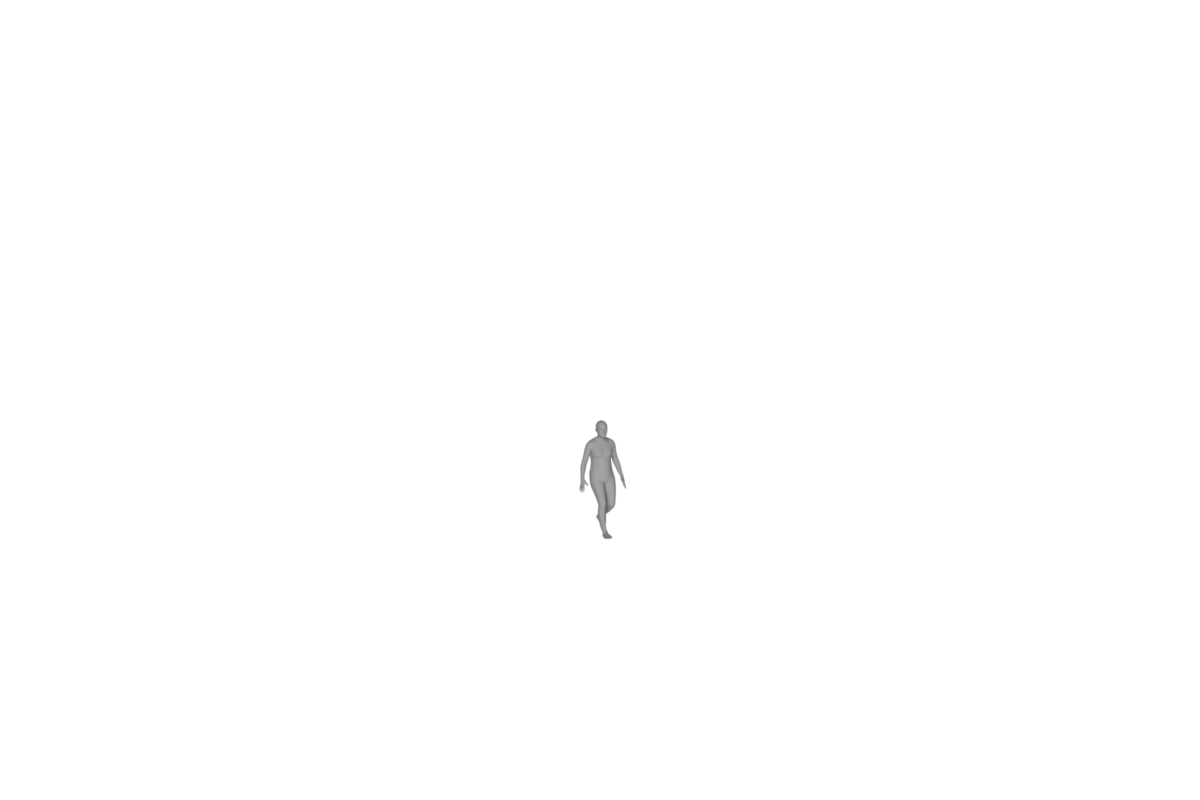
>There's something a bit off about the sequence - there is a glitch at frame 150 or so. This shows up in vertex positions in the next section as well. 

### Vertex Positions over Time

The `.gif` or image file is helpful just to check that the motion seems reasonable. Let's look at the vertex positions of the sequence in more detail.

In [26]:
vertices.shape

torch.Size([196, 6890, 3])

In [27]:
np.min(vertices[:,:,0].numpy(), axis=1).shape

(196,)

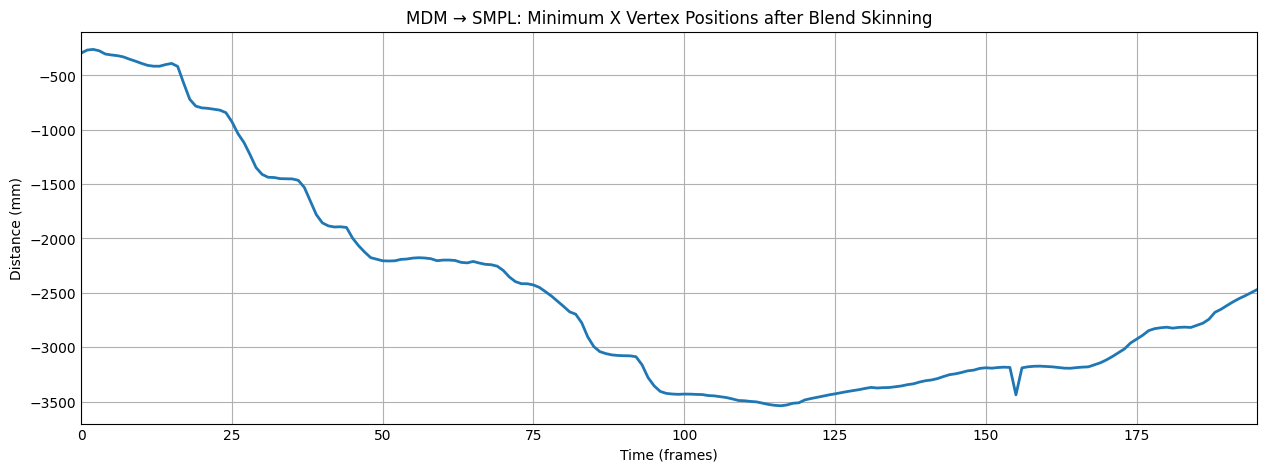

In [44]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data
axis = 0

# get the minimum position in this axis, convert positoin from meters to mm
axis_extrema = np.min(vertices[:,:,axis].numpy(), axis=1) * 1000

x = range(0, axis_extrema.shape[0])
y = axis_extrema

# plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)

ax.plot(x, y, linewidth=2.0)
ax.set(xlim=(0, axis_extrema.shape[0] - 1))

ax.set_xlabel('Time (frames)')
ax.set_ylabel('Distance (mm)')
ax.set_title('MDM → SMPL: Minimum X Vertex Positions after Blend Skinning')

plt.show()

>What's up with strange dip around frame ~150?

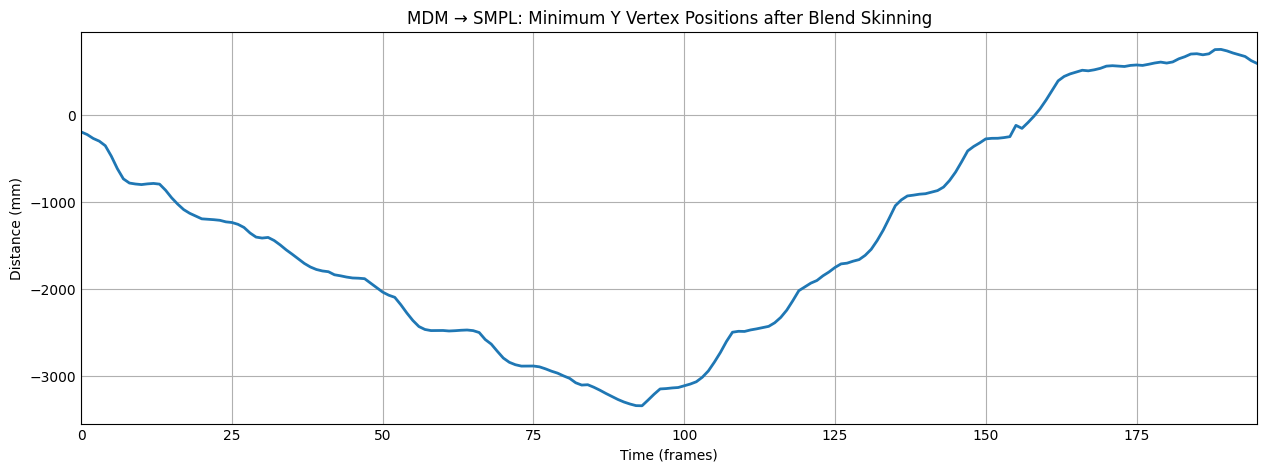

In [43]:
# make data
axis = 1

# get the minimum position in this axis, convert positoin from meters to mm
axis_extrema = np.min(vertices[:,:,axis].numpy(), axis=1) * 1000

x = range(0, axis_extrema.shape[0])
y = axis_extrema

# plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)

ax.plot(x, y, linewidth=2.0)
ax.set(xlim=(0, axis_extrema.shape[0] - 1))

ax.set_xlabel('Time (frames)')
ax.set_ylabel('Distance (mm)')
ax.set_title('MDM → SMPL: Minimum Y Vertex Positions after Blend Skinning')

plt.show()

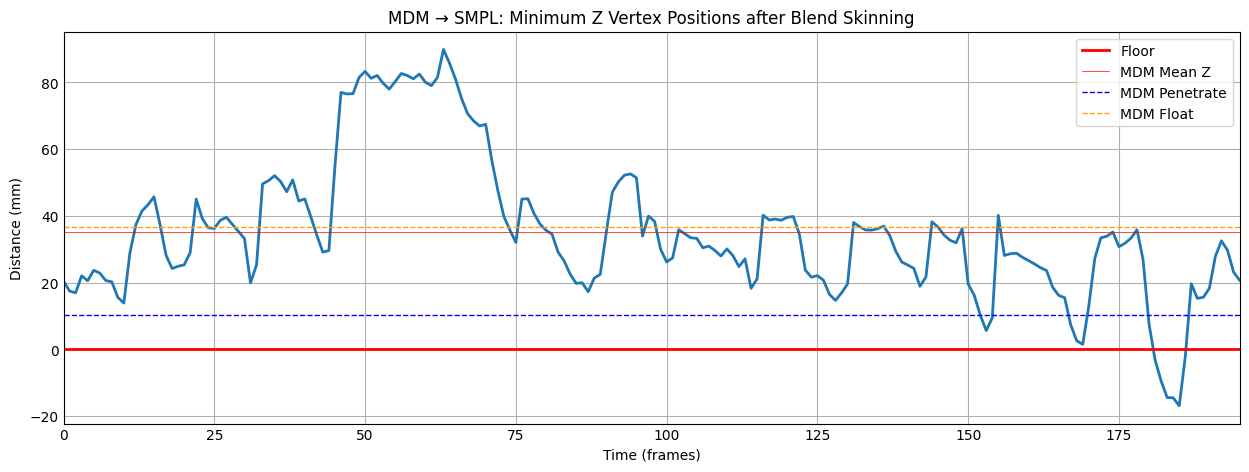

In [30]:
# make data
axis = 2

# get the minimum position in this axis, convert position from meters to mm
axis_extrema = np.min(vertices[:,:,axis].numpy(), axis=1) * 1000

x = range(0, axis_extrema.shape[0])
y = axis_extrema

# plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)

ax.plot(x, y, linewidth=2.0)

# add the floor plane
ax.axhline(0, color='red', linestyle='solid', linewidth=2.0, label="Floor")

# these are PhysDiffs reported metrics for Float and Penetrate. They clutter the graph, but feel free to 
# uncomment below:
#ax.axhline(2.601, color='red', linestyle='-.', linewidth=1.0, label="PhysDiff Float")
#ax.axhline(0.998, color='green', linestyle='-.', linewidth=1.0, label="PhysDiff Penetrate")

mean_pos = np.mean(y)
penetrate = np.mean(y[y < 0]) * -1
float_ = np.mean(y[y > 0])

ax.axhline(mean_pos, color='red', linestyle='-', linewidth=0.5, label="MDM Mean Z")
ax.axhline(penetrate, color='blue', linestyle='--', linewidth=1.0, label="MDM Penetrate")
ax.axhline(float_, color='orange', linestyle='--', linewidth=1.0, label="MDM Float")

ax.set(xlim=(0, axis_extrema.shape[0] - 1))
# ax.set_yscale('symlog')

ax.set_xlabel('Time (frames)')
ax.set_ylabel('Distance (mm)')
ax.set_title('MDM → SMPL: Minimum Z Vertex Positions after Blend Skinning')

ax.legend()

plt.show()

>This is definitely the z axis, looks a lot like footsteps.

### Joint Position Over Time

Now let's turn our attention to the XYZ positions of the joints, instead of the vertices, of the model.

From the `BodyModel` forward pass, we get the `Jtr` property which is computed by:
```python
# 4. Get the global joint location
# where J_transformed is 'The locations of the joints after applying the pose rotations'
J_transformed, A = batch_rigid_transform(rot_mats.to(dtype), J, parents, dtype=dtype)
```
>[src](https://github.com/nghorbani/human_body_prior/blob/4c246d8a83ce16d3cff9c79dcf04d81fa440a6bc/src/human_body_prior/body_model/lbs.py#L237)

In [46]:
joints = res['Jtr']
joints.shape

torch.Size([196, 52, 3])

In [47]:
l_foot_pos = joints[:,L_FOOT_ID,:]
r_foot_pos = joints[:,R_FOOT_ID,:]

In [48]:
l_foot_pos.shape

torch.Size([196, 3])

In [ ]:
l_foot_z = l_foot_pos[:,2]
r_foot_z = l_foot_pos[:

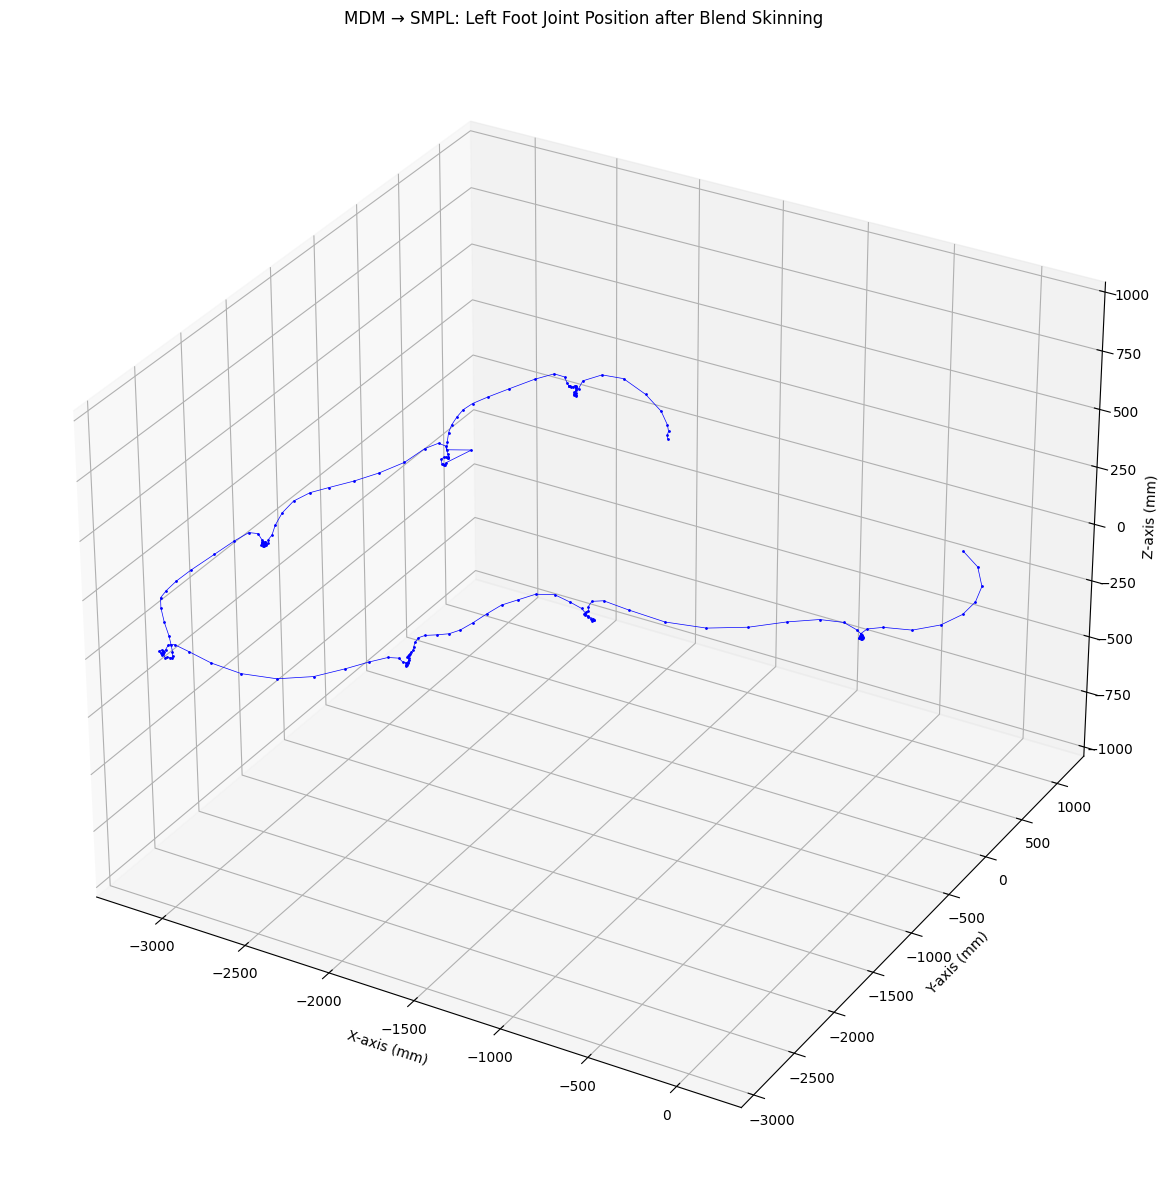

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

xyz_positions = l_foot_pos.numpy() * 1000

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot XYZ positions over time
ax.plot(xyz_positions[:, 0], xyz_positions[:, 1], xyz_positions[:, 2], c='b', marker='o', linestyle='-', markersize=1, linewidth=0.5)


# Set labels for each axis
ax.set_xlabel('X-axis (mm)')
ax.set_ylabel('Y-axis (mm)')
ax.set_zlabel('Z-axis (mm)')

ax.set_xlim(np.min(xyz_positions[:, 0]), np.max(xyz_positions[:, 0]))
ax.set_ylim(np.min(xyz_positions[:, 1]), np.max(xyz_positions[:, 1]))

# will look very extreme if set to the limits of the z dim
ax.set_zlim(-1000, 1000)

ax.set_title('MDM → SMPL: Left Foot Joint Position after Blend Skinning')

# Show the plot
plt.tight_layout()
plt.show()

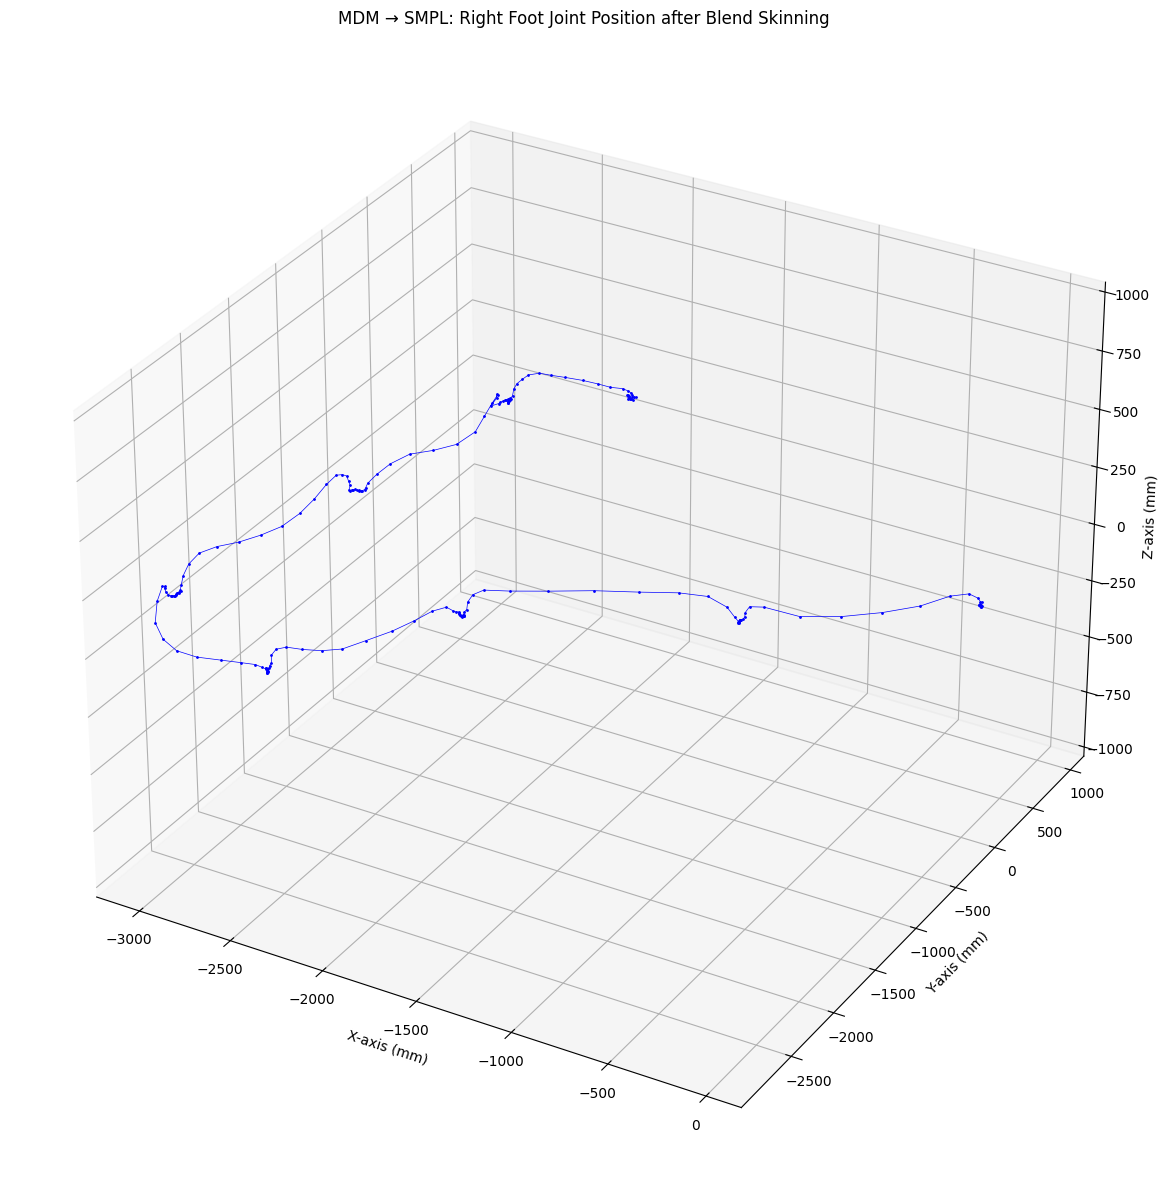

In [73]:
xyz_positions = r_foot_pos.numpy() * 1000

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot XYZ positions over time
ax.plot(xyz_positions[:, 0], xyz_positions[:, 1], xyz_positions[:, 2], c='b', marker='o', linestyle='-', markersize=1, linewidth=0.5)


# Set labels for each axis
ax.set_xlabel('X-axis (mm)')
ax.set_ylabel('Y-axis (mm)')
ax.set_zlabel('Z-axis (mm)')

ax.set_xlim(np.min(xyz_positions[:, 0]), np.max(xyz_positions[:, 0]))
ax.set_ylim(np.min(xyz_positions[:, 1]), np.max(xyz_positions[:, 1]))

# will look very extreme if set to the limits of the z dim
ax.set_zlim(-1000, 1000)

ax.set_title('MDM → SMPL: Right Foot Joint Position after Blend Skinning')

# Show the plot
plt.tight_layout()
plt.show()

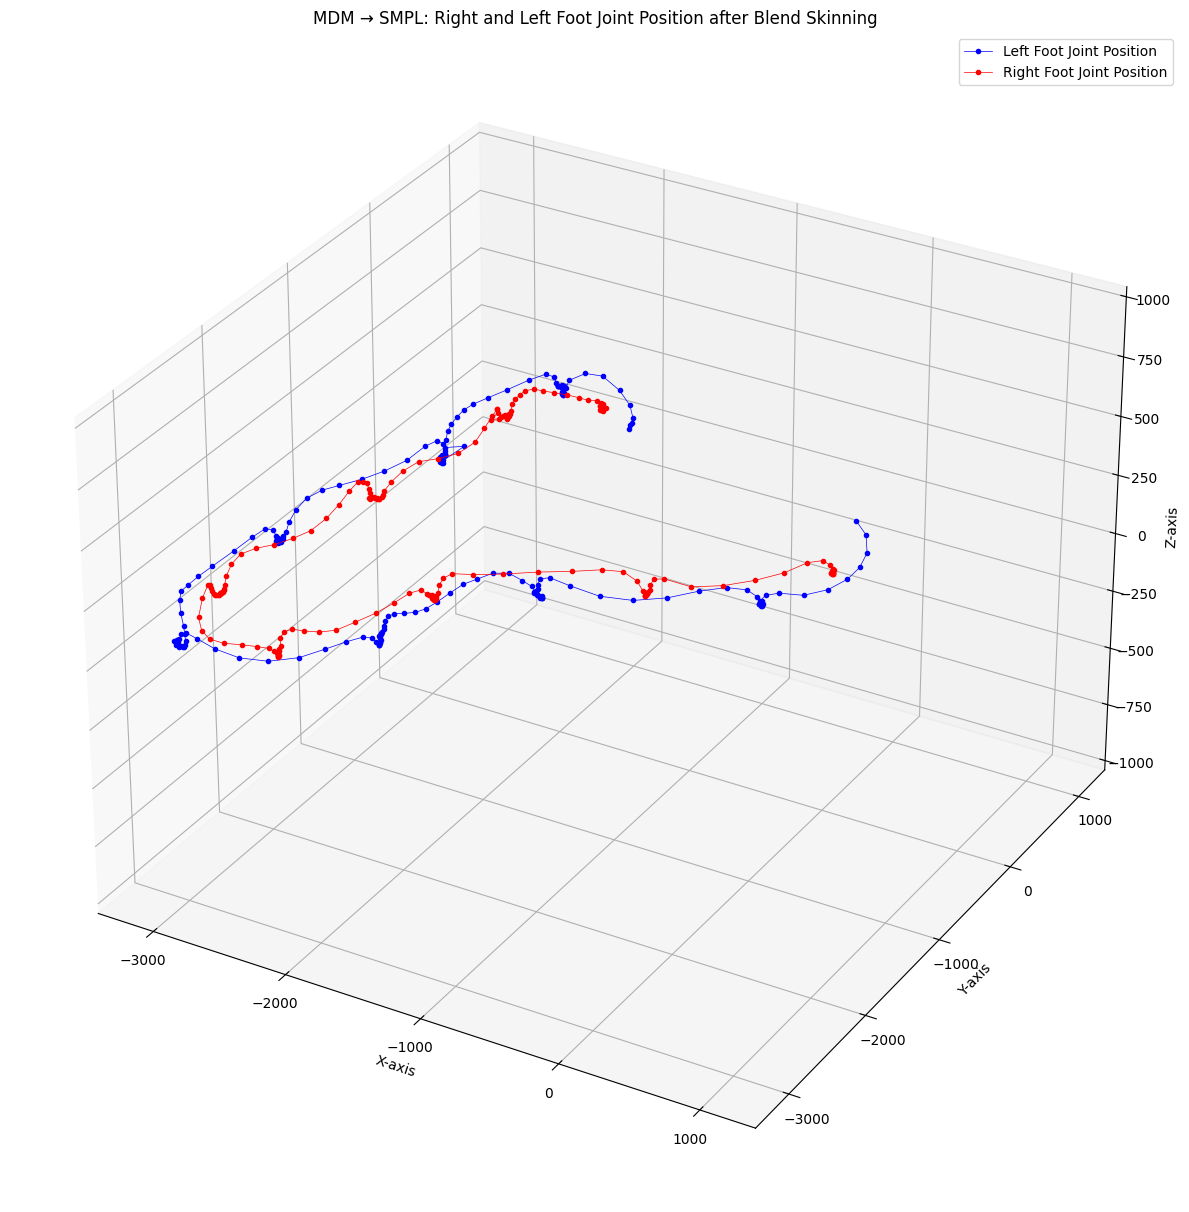

In [78]:
xyz_positions1 = l_foot_pos.numpy() * 1000
xyz_positions2 = r_foot_pos.numpy() * 1000

# Set the figure size to be 12 inches in width and 4 inches in height
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot the first sequence with a blue line and markers
ax.plot(xyz_positions1[:, 0], xyz_positions1[:, 1], xyz_positions1[:, 2], c='b', marker='o', linestyle='-', markersize=3, linewidth=0.5, label='Left Foot Joint Position')

# Plot the second sequence with a red line and markers
ax.plot(xyz_positions2[:, 0], xyz_positions2[:, 1], xyz_positions2[:, 2], c='r', marker='o', linestyle='-', markersize=3, linewidth=0.5, label='Right Foot Joint Position')

# Set labels for each axis
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set axis limits based on the extrema of both sequences
min_limit = min(np.min(xyz_positions1), np.min(xyz_positions2))
max_limit = max(np.max(xyz_positions1), np.max(xyz_positions2))
ax.set_xlim(min_limit, max_limit)
ax.set_ylim(min_limit, max_limit)
ax.set_zlim(-1000, 1000)

# Add a legend to differentiate between the sequences
ax.legend()

# Automatically adjust subplot parameters to give specified padding
plt.tight_layout()

ax.set_title('MDM → SMPL: Right and Left Foot Joint Position after Blend Skinning')

# Show the plot
plt.show()

Follow up - what's the relationship between the lowest vertex position and the joint positions?

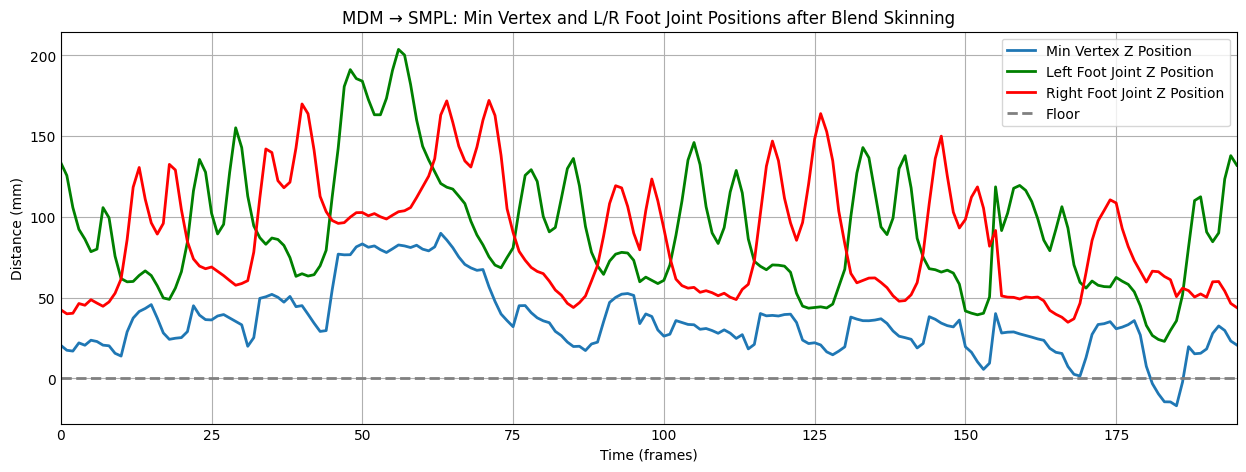

In [102]:
# get the minimum position in this axis, convert position from meters to mm
axis_extrema = np.min(vertices[:,:,2].numpy(), axis=1) * 1000

x = range(0, axis_extrema.shape[0])
y = axis_extrema

# plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)

ax.plot(x, y, linewidth=2.0, label='Min Vertex Z Position')

y_l_foot = l_foot_pos[:,2].numpy() * 1000
ax.plot(x, y_l_foot, linewidth=2.0, label='Left Foot Joint Z Position', color='Green')

y_r_foot = r_foot_pos[:,2].numpy() * 1000
ax.plot(x, y_r_foot, linewidth=2.0, label='Right Foot Joint Z Position', color='Red')

# add the floor plane
ax.axhline(0, color='gray', linestyle='--', linewidth=2.0, label="Floor")

ax.set(xlim=(0, axis_extrema.shape[0] - 1))

ax.set_xlabel('Time (frames)')
ax.set_ylabel('Distance (mm)')
ax.set_title('MDM → SMPL: Min Vertex and L/R Foot Joint Positions after Blend Skinning')

ax.legend()
plt.show()

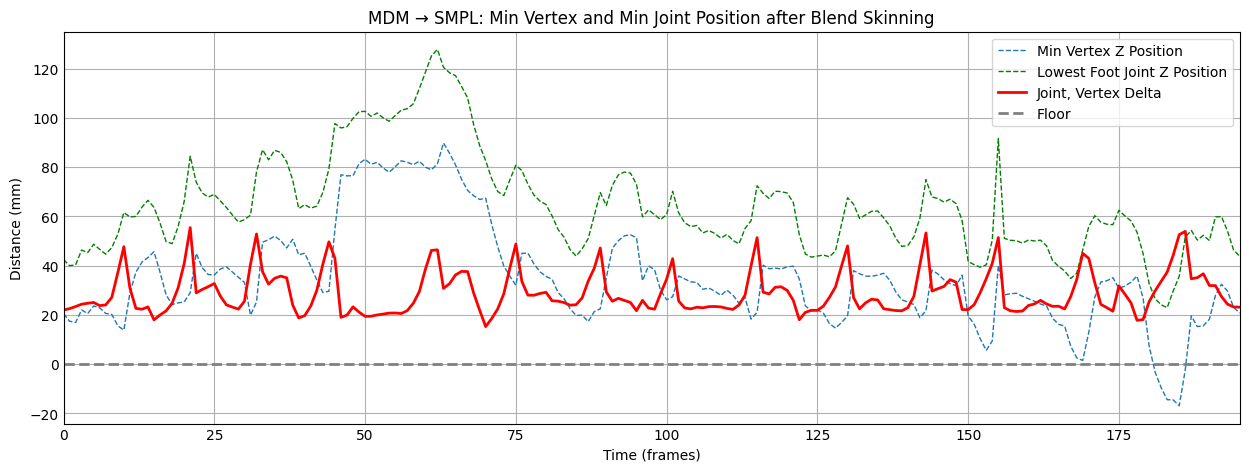

In [109]:
# get the minimum position in this axis, convert position from meters to mm
axis_extrema = np.min(vertices[:,:,2].numpy(), axis=1) * 1000

x = range(0, axis_extrema.shape[0])
y = axis_extrema

# plot
fig, ax = plt.subplots()
fig.set_size_inches(12, 4)

ax.plot(x, y, linewidth=1.0, label='Min Vertex Z Position', linestyle='--')

y_l_foot = l_foot_pos[:,2].numpy() * 1000
y_r_foot = r_foot_pos[:,2].numpy() * 1000

y_lowest_joint = np.minimum(y_l_foot, y_r_foot)

ax.plot(x, y_lowest_joint, linewidth=1.0, label='Lowest Foot Joint Z Position', color='Green', linestyle='--')


# plot the difference between the joints and the vertices position
y_joint_vertex_drift = y_lowest_joint - y
ax.plot(x, y_joint_vertex_drift, linewidth=2.0, label='Joint, Vertex Delta', color='Red')

# add the floor plane
ax.axhline(0, color='gray', linestyle='--', linewidth=2.0, label="Floor")

ax.set(xlim=(0, axis_extrema.shape[0] - 1))

ax.set_xlabel('Time (frames)')
ax.set_ylabel('Distance (mm)')
ax.set_title('MDM → SMPL: Min Vertex and Min Joint Position after Blend Skinning')

ax.legend()
plt.show()

In [110]:
print(np.max(y_joint_vertex_drift), np.min(y_joint_vertex_drift))

55.474754 15.243111


Based on this single sequence, it seems like the joint is at least >15 mm away from the lowest vertex, and is at most <60 mm away from it. Another exercise could be to examine the relationship between the ankle joint positions and the minimum vertex, as these are the foot joint positions. 

### Physics Obeying Metrics

Reference implementations
- Penetration: [uhc/smpllib/smpl_eval.py (line 125)](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/smpllib/smpl_eval.py#L125)
- Skate: [uhc/smpllib/smpl_eval.py (line 138)](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/smpllib/smpl_eval.py#L138)
- Float: `n/a`

In [156]:
from typing import Tuple

def get_float_penetrate(vertices, floor_plane_z_pos: float = 0.0) -> Tuple[float, float]:
    # torch to numpy, and extract the z position of all vertices
    z_positions = vertices[:,:,2].numpy()
    
    # get the minimum z position of any vertex in the sequence
    min_vertex_z_pos_meters = np.min(z_positions, axis=1)
    
    # meters to millimeters
    min_vertex_z_pos_mm = min_vertex_z_pos_meters * 1000
    
    # compute float and penetrate
    z = min_vertex_z_pos_mm
    
    p = z[z < floor_plane_z_pos]
    pen = 0.0
    if np.any(p):
        # if nothing clips through the floor, it should be 0
        pen = np.mean(p) * -1
    
    f = z[z > floor_plane_z_pos]
    flo = 0.0
    if np.any(f):
        # if nothing is above the floor (definitely more rare than no penetrate), float should
        # be 0
        flo = np.mean(f)
    
    return flo, pen

In [157]:
# SOTA float (from PhysDiff, is 2.601)
# MDM float on HumanML3D (as reported by PhysDiff Table 1, is 18.876)

# SOTA penetrate (from PhysDiff, is 0.998)
# MDM penetrate on HumanML3D (as reported by PhysDiff Table 1, is 11.291)

# keep in mind that the above metrics are for an entire evaluation set, while the below are just for a single sequence
m_float, m_penetrate = get_float_penetrate(vertices)

print("Float: {:.3f}, Penetrate: {:.3f}".format(m_float, m_penetrate))

Float: 36.603, Penetrate: 10.141


#### Skate

Also known as "Foot Skating", "Foot Skate", or "Foot Sliding". From PhysDiff:
>For foot sliding (Skate), we find foot joints that contact the ground in two adjacent frames and compute their average horizontal displacement within the frames.

UHC [implements](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/smpllib/smpl_eval.py#L138) it as this:
```python
def compute_skate(vert, info):
    skate = []
    for t in range(vert.shape[0] - 1):
        # find foot anchors that contact the ground in two adjacent frames...
        cind = (vert[t, :, 2] <= info["floor_z"]) & (vert[t + 1, :, 2] <= info["floor_z"])
        if torch.any(cind):
            # ...and compute their average horizontal displacement within the frames
            offset = vert[t + 1, cind, :2] - vert[t, cind, :2]
            skate_i = torch.norm(offset, dim=1).mean().item() * 1000
        else:
            # anchors are not in contact with the ground, no skating
            skate_i = 0.0
        
            skate.append(skate_i)
    return skate
```

This is alright, but it is tracking the displacement of specific *vertices* between frames - not the foot *joints* as PhysDiff did. In some sense, it is more defensible to track sliding displacement in terms of the joints and not the vertices. In my opinion, that is more interpretable. The problem is that the foot joint may not necessarily intersect with 
the floor plane even though the vertices do. Thus the approach here is to:
1. Identifty consecutive frames where the feet touch the ground through the positions of vertexes
2. From those, check if the foot joint is close to the vertex
3. Measure the displacement of the foot joint between frames

In [158]:
def get_skate(body_model_result, compute_by_vertex: bool = False, l_foot_joint: int = 10, r_foot_joint: int = 11, floor_plane_z_pos: float = 0.0):
    vertices, joints = body_model_result['v'], body_model_result['Jtr']
    
    skate = []
    for t in range(vertices.shape[0] - 1):
        # find vertices that are on or beneath the floor on two consecutive frames
        cind = (vertices[t, :, 2] <= floor_plane_z_pos) & (vertices[t + 1, :, 2] <= floor_plane_z_pos)
        
        if torch.any(cind):
            if compute_by_vertex:
                offset = vertices[t + 1, cind, :2] - vertices[t, cind, :2]
                s = torch.norm(offset, dim=1).mean().item() * 1000
            else:
                l_foot_xy_a = joints[t, l_foot_joint, :2]
                l_foot_xy_b = joints[t + 1, l_foot_joint, :2]
                l_foot_displace = torch.norm(l_foot_xy_b - l_foot_xy_a).mean().item() * 1000

                r_foot_xy_a = joints[t, r_foot_joint, :2]
                r_foot_xy_b = joints[t + 1, r_foot_joint, :2]
                r_foot_displace = torch.norm(r_foot_xy_b - r_foot_xy_a).mean().item() * 1000
                
                s = max(l_foot_displace, r_foot_displace)
            
            skate.append(s)
        else:
            # does it make sense to record the skate as 0.0 when the joints aren't in contact with the ground?
            # it seems like this is how PhysDiff and UHC do it
            skate.append(0.0)
    
    return np.mean(skate)

In [159]:
# for context, PhysDiff's skate is 0.512 and MDM's is 1.406 (as reported by PhysDiff)
# keep in mind that those metrics are for an entire evaluation set, while the below are just for a single sequence
joints_skate = get_skate(res)
vertex_skate = get_skate(res, compute_by_vertex=True)
      
print("Joint Skate: {:.3f}, Vertex Skate: {:.3f}".format(joints_skate, vertex_skate))

Joint Skate: 0.527, Vertex Skate: 0.255


### Results

Putting it all together.

EDIT: this will not work anymore, see `physics_metrics.ipynb`

In [ ]:
# this sequence has really bad floating...
motion_idx = 1
mdm_single_motion = mdm_output[None][0]['motion'][motion_idx, :]
mdm_motion_seq = mdm_single_motion.transpose(2, 0, 1)

skin_result = mdm_to_skin_result(mdm_motion_seq)
compute_physics_metrics_for_skin_result(skin_result)

2024-01-01 21:54:47.321 | INFO     | human_body_prior.src.human_body_prior.tools.model_loader:load_model:77 - No GPU detected. Loading on CPU!
2024-01-01 21:54:47.354 | INFO     | human_body_prior.src.human_body_prior.tools.model_loader:load_model:97 - Loaded model in eval mode with trained weights: ./human_body_prior/support_data/dowloads/vposer_v2_05/snapshots/V02_05_epoch=08_val_loss=0.03.ckpt
VPoser Advanced IK: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.48s/it]


(55.828598, 0.0, 0.0)

This is a bit of an issue with the skate metric... if no foot vertices ever touch the 'floor', then it will be reported as 0. This seems incorrect, since the sequence could be floating above the floor but still exhibit a sliding behavior. 

In [163]:
motion_idx = 2
mdm_single_motion = mdm_output[None][0]['motion'][motion_idx, :]
mdm_motion_seq = mdm_single_motion.transpose(2, 0, 1)

skin_result = mdm_to_skin_result(mdm_motion_seq)
compute_physics_metrics_for_skin_result(skin_result)

2024-01-01 21:56:17.725 | INFO     | human_body_prior.src.human_body_prior.tools.model_loader:load_model:77 - No GPU detected. Loading on CPU!
2024-01-01 21:56:17.809 | INFO     | human_body_prior.src.human_body_prior.tools.model_loader:load_model:97 - Loaded model in eval mode with trained weights: ./human_body_prior/support_data/dowloads/vposer_v2_05/snapshots/V02_05_epoch=08_val_loss=0.03.ckpt
VPoser Advanced IK: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:26<00:00, 26.31s/it]


(34.254505, 3.5767555236816406, 0.5202222663240555)

# Unstructured Notes on Physics Simulators and Implementations

These are notes I wrote while trying to figure out how to implement this. It is not necessary to read, nor is it organized.

...

## Units

What exactly are the units of MuJoCo? 

In the official MuJoCo repository, in this issue, a contributor to the codebase says:
>The units of length are indeed undefined, you are free to interpret them as you like (metre, centimetre, inch etc.)
>
>People very often add a layer of colliding primitive geoms alongside their non-colliding meshes (which are used for visualisation and inertial properties), since primitive collisions are faster to compute than mesh collisions.

src: [LINK](https://github.com/google-deepmind/mujoco/issues/60)

This doesn't make a lot of sense to me because constants like gravity (at least in really simple mechanics) have fixed units like $m/s^2$. The UHC codebase interprets the MuJoCo values as meters, so to obtain the metrics for Penetrate, Float, and Skate - they must multiply the positions of the vertices / joints by $1000$ to convert to millimeters. 

There is a top search result on Google that says MuJoCo will use the unit specified in a `.stl` file, which UHC does use for the skeleton geometry. It says:
>Mujoco uses the units specified in your STL models.

src: [LINK](https://studywolf.wordpress.com/2020/03/22/building-models-in-mujoco/#:~:text=Mujoco%20uses%20the%20units%20specified,%3E%20Length%20Units%20%3E%200.0m.)

This quote seems to contradict the STL spec, which says:
>The StL file does not contain any scale information; the coordinates are in arbitrary units.

src: [LINK](http://www.fabbers.com/tech/STL_Format), found from Wikipedia, src: [LINK](https://en.wikipedia.org/wiki/STL_(file_format))

So in short, the units of the models in MuJoCo are a bit ambiguous - but I guess we are interpreting them as meters. It seems clear that several works agree to characterize these metrics in millimeters, but because they use different physics simulators (e.g. MuJoCo, IsaacGym, Brax), then they need to handle the conversion accordingly.

The `.stl` files used by UHC are locaed in `assets/mujoco_models/geom`. Here is an example: [Pelvis.stl](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/assets/mujoco_models/geom/Pelvis.stl)

By contrast, here is how units are defined in IsaacGym. These kinds of parameters can be set in the environment `yaml` file. For example, the humanoid one ([Humanoid.yaml](https://github.com/NVIDIA-Omniverse/IsaacGymEnvs/blob/aeed298638a1f7b5421b38f5f3cc2d1079b6d9c3/isaacgymenvs/cfg/task/Humanoid.yaml#L42)) defines a few interesting things:
```yml
sim:
  dt: 0.0166 # 1/60 s
  substeps: 2
  up_axis: "z"
  use_gpu_pipeline: ${eq:${...pipeline},"gpu"}
  gravity: [0.0, 0.0, -9.81]
  physx:
    num_threads: ${....num_threads}
```



### Starting Out: Evaluating Physics Metrics in UHC

In UHC we convert from the state of MuJoCo's engine to SMPL. This is done by a function called `convert_2_smpl_params`: [LINK](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/envs/humanoid_im.py#L127C1-L127C1)
- the function takes as input, the state of MuJoCo when an imitation agent is trying to imitate a sequence in the simulator. That is called in the `eval_seq` function for an imitation learning agent, for example here in `AgentCopycat`: [LINK](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/agents/agent_copycat.py#L449C23-L449C23)
- in this function, the ground truth state of MuJoCo is given by:
```python 
res["gt"].append(self.env.get_expert_attr("qpos", self.env.get_expert_index(t)).copy())
```

What are these arguments?
- `self.env`: very likely to be an instance of `HumanoidEnv`, which inherits from `MujocoEnv`: [src](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/khrylib/rl/envs/common/mujoco_env.py). This is basically just a wrapper over [mujoco-py](https://github.com/openai/mujoco-py)'s interface. 
    - importantly, `HumanoidEnv` will load the `smpl_robot.Robot` class. 
    - this is notable because `smpl_robot.Robot` uses the MuJoCo XML to define the SMPL skeleton inside MuJoCo. We are interested in this file because it specifies important global information to MuJoCo. 
    
```python
self.sim_model = load_model_from_xml(self.smpl_robot.export_xml_string().decode("utf-8"))
```
>src: [LINK](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/envs/humanoid_im.py#L83C98-L83C98)

So when `self.env.get_expert_attr` is called, it is calling:
```python
return self.expert[attr][ind].copy()
```
>[src](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/envs/humanoid_im.py#L1333)

Where `self.expert` is loaded by `load_expert`: [LINK](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/envs/humanoid_im.py#L182) in the constructor of `HumanoidEnv`: 
```python
def setup_env(self):
    cfg, device, dtype = self.cfg, self.device, self.dtype
    random_expert = self.data_loader.sample_seq()
    self.env = HumanoidEnv(
        cfg,
        init_expert=random_expert,
        data_specs=cfg.data_specs,
        mode="train",
        no_root=cfg.no_root,
    )
```
>[src](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/agents/agent_copycat.py#L126)

and `self.data_loader` is an instance of `DatasetAMASSSingle`, first defined in `agent_copycat.py` line 120: [src](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/agents/agent_copycat.py#L120). `sample_seq` implements a custom sampling method from UHC - but in this context we can think of it as just loading a random AMASS sequence to imitate.

But the expert must have the attribute `"qpos"` defined, since that is what `self.env.get_expert_attr` is called to fetch. `load_expert` gives the AMASS sequence this property through the function `smpl_to_qpose`:
```python
def load_expert(self, expert_data, reload_robot=True):
    # ...

    expert_qpos = smpl_to_qpose(
        # pose_aa is directly from the AMASS expert, from expert_data["pose_aa"]
        pose=pose_aa,
        mj_model=self.model,
        # trans is also from AMASS, given by expert_data["trans"]
        trans=trans.squeeze(),
        model=self.cc_cfg.robot_cfg.get("model", "smpl"),
        count_offset=self.cc_cfg.robot_cfg.get("mesh", True),
    )

    self.expert["meta"] = expert_meta

    # self.humanoid is defined on line 99, as self.humanoid = Humanoid(model=self.model)
    self.expert.update(self.humanoid.qpos_fk(torch.from_numpy(expert_qpos)))  # Not using this since the masterfoot stuff...
```
>Assuming we are not using quaternions, and instead using Euler angles [src](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/envs/humanoid_im.py#L203C9-L209C10)

>[!warning]
>The comment in the above says that the information from `self.humanoid.qpos_fk` is not used since the `masterfoot` stuff, but I am not sure what `masterfoot` is. 

What are these arguments?
- recall that `self` is an instance of [HumanoidEnv](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/envs/humanoid_im.py#L48)
- `self.model` is given by a function from `mujoco_py`, see line 1448: [LINK](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/envs/humanoid_im.py#L1448), which says: `self.model = mujoco_py.load_model_from_xml(xml_str)`. Docs for that in mujoco-py are here: [LINK](https://openai.github.io/mujoco-py/build/html/reference.html#mujoco_py.load_model_from_xml)

You can find the source of the function `smpl_to_qpose` here: [LINK](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/smpllib/smpl_mujoco.py#L543)

For convenience, it is also pasted below:
```python
def smpl_to_qpose(
    pose,
    mj_model,
    trans=None,
    normalize=False,
    random_root=False,
    count_offset=True,
    use_quat=False,
    euler_order="ZYX",
    model="smpl",
):
    """
    Expect pose to be batch_size x 72
    trans to be batch_size x 3
    differentiable 
    """
    if trans is None:
        trans = np.zeros((pose.shape[0], 3))
        trans[:, 2] = 0.91437225
    if normalize:
        pose, trans = normalize_smpl_pose(pose, trans, random_root=random_root)

    if not torch.is_tensor(pose):
        pose = torch.tensor(pose)

    if model == "smpl":
        joint_names = SMPL_BONE_ORDER_NAMES
        if pose.shape[-1] == 156:
            pose = smplh_to_smpl(pose)
    elif model == "smplh":
        joint_names = SMPLH_BONE_ORDER_NAMES
        if pose.shape[-1] == 72:
            pose = smpl_to_smplh(pose)
    elif model == "smplx":
        joint_names = SMPLH_BONE_ORDER_NAMES
        if pose.shape[-1] == 72:
            pose = smpl_to_smplh(pose)

    num_joints = len(joint_names)
    num_angles = num_joints * 3
    smpl_2_mujoco = [joint_names.index(q) for q in list(get_body_qposaddr(mj_model).keys()) if q in joint_names]

    pose = pose.reshape(-1, num_angles)

    curr_pose_mat = angle_axis_to_rotation_matrix(pose.reshape(-1, 3)).reshape(pose.shape[0], -1, 4, 4)

    curr_spose = sRot.from_matrix(curr_pose_mat[:, :, :3, :3].reshape(-1, 3, 3).numpy())
    if use_quat:
        curr_spose = curr_spose.as_quat()[:, [3, 0, 1, 2]].reshape(curr_pose_mat.shape[0], -1)
        num_angles = num_joints * (4 if use_quat else 3)
    else:
        curr_spose = curr_spose.as_euler(euler_order, degrees=False).reshape(curr_pose_mat.shape[0], -1)

    curr_spose = curr_spose.reshape(-1, num_joints, 4 if use_quat else 3)[:, smpl_2_mujoco, :].reshape(-1, num_angles)
    if use_quat:
        curr_qpos = np.concatenate([trans, curr_spose], axis=1)
    else:
        root_quat = rotation_matrix_to_quaternion(curr_pose_mat[:, 0, :3, :])
        curr_qpos = np.concatenate((trans, root_quat, curr_spose[:, 3:]), axis=1)

    if count_offset:

        curr_qpos[:, :3] = trans + mj_model.body_pos[1]

    return curr_qpos
```

### Humanoid Class

The `Humanoid` class ([src](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/smpllib/torch_smpl_humanoid.py#L21)) is used by `HumanoidEnv`. Thus far we have only seen it used during the call `self.humanoid.qpos_fk` (where `self` is a HumanoidEnv instance). That function, `qpos_fk` is defined here: [LINK](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/smpllib/torch_smpl_humanoid.py#L155)

It is this function that gives the `self.expert` the `"qpos"` attribute / key... but it doesn't alter the input `qpos` at all. So effectively, what the function `load_expert` does is:
```python
def load_expert(self, expert_data, reload_robot=True):
    # ...

    expert_qpos = smpl_to_qpose(
        # pose_aa is directly from the AMASS expert, from expert_data["pose_aa"]
        pose=pose_aa,
        mj_model=self.model,
        # trans is also from AMASS, given by expert_data["trans"]
        trans=trans.squeeze(),
        model=self.cc_cfg.robot_cfg.get("model", "smpl"),
        count_offset=self.cc_cfg.robot_cfg.get("mesh", True),
    )

    self.expert["meta"] = expert_meta

    # self.expert.update(self.humanoid.qpos_fk(torch.from_numpy(expert_qpos)))  # Not using this since the masterfoot stuff...
    # if the above is really not being used, then we can just do this:
    self.expert["qpos"] = expert_qpos
```

### SMPL Robot / MuJoCo

What is `SMPL Robot`? According to the UHC repo:
>The SMPL robot, an adaption of Robot class from [Transform2Act](https://github.com/Khrylx/Transform2Act), is an automatic humanoid generation class that supports SMPL, SMPL-H, and SMPL-X models. It creates XML file humanoid model for MuJoCo simulator, and can create humanoid of different gender and body shape. It supports both capsule based and mesh based models. We use SMPL Robot to create SMPL models to simulate on-the-fly when training our UHC with different body shapes.

Note that the difference between `smpl_robot.py` and `smpl_local_robot.py` is that the latter supports IsaacGym but the former does not (only MuJoCo). 

Let's examine the XML file that `smpl_robot.Robot` could use to define itself in MuJoCo. Unfortunately, the file is given an uninformative name of `test_good.xml` in the UHC repo. Find that file here: [LINK](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/test_good.xml#L78)

In line `78` of the file, we see that the Floor plane is defined at XYZ position `(0, 0, 0)`: 
```xml
<geom conaffinity="1" condim="3" name="floor" pos="0 0 0" rgba="0.8 0.9 0.8 1" size="100 100 .2" type="plane" material="MatPlane"/>
```

It seems like this explains why the `floor_z` plane is set to `0` in evaluation `uhc/smpllib/smpl_eval.py compute_metrics` [LINK](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/smpllib/smpl_eval.py#L104C7-L104C7)




### Other Implementation Details

In UHC, they convert from the result of MuJoCo into SMPL parameters using a custom class called `SMPLConverter` ([src](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/smpllib/smpl_mujoco.py#L36))

The converter calls this function: `qpos_new_2_smpl` to extract the `qpos` values of specific SMPL joints ([src](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/smpllib/smpl_mujoco.py#L235C20-L235C20)). The name of this function is a bit misleading, because it does not convert the `qpos` to SMPL parameters - it just gets the position that would correspond to a SMPL skeleton. 

The function `qpos_to_smpl` takes the ouput of `qpos_new_2_smpl` and produces the `pose` (in axis angles) and `translation` vectors that can be given to a SMPL NN layer: [LINK](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/smpllib/smpl_mujoco.py#L738). This also calls [scipy.spatial.transform.Rotation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.html#scipy.spatial.transform.Rotation) to convert quaternions or euler angles to rotation vectors (via [Rotation.as_rotvec](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.as_rotvec.html)). From the docs:
>A rotation vector is a 3 dimensional vector which is co-directional to the axis of rotation and whose norm gives the angle of rotation [1].

Now, we can pass the pose axis angles and translation vector to the `Robot` class, aka the 'SMPL Robot' that is part of UHC. 

The robot uses the function `get_joint_vertices` to produces the vertices and the joints of a SMPL mesh given the pose axis angles, translation vector, and (optionally) the betas (body shape vector), [src](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/smpllib/smpl_robot.py#L1005)
- the function calls `uhc/smpllib/smpl_parser.py`, which essentially just uses [SMPLX](https://github.com/vchoutas/smplx) to compute the forward pass of the SMPL NN layer: [src](https://github.com/ZhengyiLuo/UniversalHumanoidControl/blob/d2bec1793858fe5f71ef79c6643d16a3f563ee65/uhc/smpllib/smpl_parser.py#L607)

[^1]: src https://en.wikipedia.org/wiki/Axis%E2%80%93angle_representation#Rotation_vector